# CIFAR10 Classification Learning Curve using Keras

In this notebook, I train a simple CNN on the various sample sizes of the CIFAR10 dataset. To plot the learning curve, I train the model to convergence when the model is exposed to varying training set sizes.

We expect that as the size of dataset increases, the rate performance gains from exposing the model to more data should decrease. If not, then we hypothesise that the model could benefit from training on a larger dataset (the model still has capacity to learn).

First, let's import necessary packages.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

Select the GPU to run on.

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


## The CIFAR10 Dataset
Now, let's load the CIFAR10 dataset:


In [3]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('Training examples shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Testing examples shape: ', X_test.shape)
print('Testing labels shape: ', y_test.shape)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Training examples shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Testing examples shape:  (10000, 32, 32, 3)
Testing labels shape:  (10000, 1)


The training set includes 50,000 RGB 32x32 images with a corresponding label vector.

The test set includes 10,000 images, again with a label vector.

In [4]:
num_train = X_train.shape[0]
num_test = X_test.shape[0]

num_classes = len(np.unique(y_train))
print(num_classes)

10


Let's visualise some random examples from the training dataset.

*Code from CS231n Assignment 1*

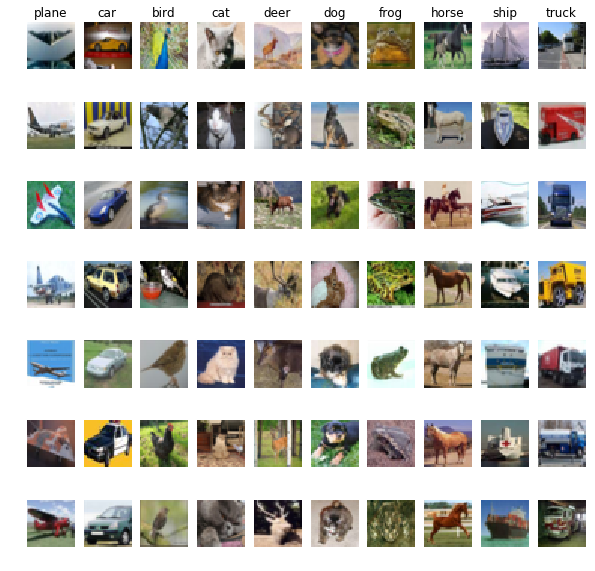

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 7
plt.figure(figsize=(10,10))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Each label vector row contains an integer (from 0 to 9) which categorises the class of the image. For image classification, we need to convert this to a binary matrix where each column indicates that the image belongs to a particular class.

In [6]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print('Training labels shape: ', y_train.shape)
print('Testing labels shape: ', y_test.shape)

Training labels shape:  (50000, 10)
Testing labels shape:  (10000, 10)


Now we pre-process the testing and training data y performing mean subtraction. Geometrically this centers the data around the origin along each dimension. Note that we save the mean of the training data to apply that to the testing data.

Normally normalisation would be performed to ensure that the scale of each feature is approximately equal. This ensures that each feature is approximately of equal importance to the learning algorithm. In the case of images, we know that each feature (pixel) are already in the same scale (0 to 255) so this step is not necessary. 

In [7]:
# perform mean subtraction
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_mean = np.mean(X_train, axis = 0)
X_train -= X_mean
X_test -= X_mean
X_train /= 255
X_test /= 255

We configure an image data generator to perform data augmentation on our training set. This is to reduce the chance of overfitting given that the model has a large number of parameters.

In [8]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

## The Model

Let's start by defining the CNN model. We use four convolution layers with ReLU activations, inserting max pooling layers intermittently. 

In [9]:
from keras import models
from keras.layers import Conv2D, Dropout, MaxPooling2D, Activation, Flatten, Dense 
from keras.constraints import maxnorm

def build_6layer_cnn(input_shape, num_classes):
    model = models.Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024,activation='relu',kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    return model

Now we train the model over `num_iterations` training runs. The training data for each run is randomly sampled from the 50,000 original training images. Over the training runs, the model is exposed to increasing sizes of training set.

In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD

# hyperparameters
batch_size=64
epochs = 50
lrate = 0.01
num_iterations = 20

# configure callbacks
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')
callbacks = [early]

# list to store model training stats
histories = []

step_size = num_train // num_iterations
for train_size in range(step_size, num_train + step_size, step_size):
    
    print('Training on sample size: {}'.format(train_size))    
    sample_inds = np.random.choice(num_train, size=train_size)
    X_sample = X_train[sample_inds, :, :, :]
    y_sample = y_train[sample_inds, :]
    
    datagen.fit(X_sample)
    
    model = build_6layer_cnn(X_train.shape[1:], num_classes)
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=SGD(lr=lrate, decay=1e-6, momentum=0.9, nesterov=True), 
                  metrics=['accuracy'])

    history = model.fit_generator(datagen.flow(X_sample, y_sample, batch_size=batch_size),
                                  steps_per_epoch=len(X_sample) // batch_size,
                                  epochs=epochs,
                                  validation_data=(X_test, y_test),
                                  callbacks=callbacks,
                                  verbose=0)
    
    histories.append(history)
    
    model.save('models/cnn-learning-curve-sample-size-{}.hdf5'.format(train_size))
    
print('Done')

Training on sample size: 2500
Training on sample size: 5000
Training on sample size: 7500
Training on sample size: 10000
Training on sample size: 12500
Training on sample size: 15000
Training on sample size: 17500
Training on sample size: 20000
Training on sample size: 22500
Training on sample size: 25000
Training on sample size: 27500
Training on sample size: 30000
Training on sample size: 32500
Training on sample size: 35000
Training on sample size: 37500
Training on sample size: 40000
Training on sample size: 42500
Training on sample size: 45000
Training on sample size: 47500
Training on sample size: 50000
Done


## Analysis

First, let's plot the accuracy vs. dataset size

In [11]:
val_loss = []
val_acc = []

# load and evaluate the models
for train_size in range(step_size, num_train + step_size, step_size):
    model = models.load_model('models/cnn-learning-curve-sample-size-{}.hdf5'.format(train_size))
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
    print('sample_size: {} | Test Loss: {}, Test Accuracy: {}'.format(train_size, test_loss, test_acc))
    val_loss.append(test_loss)
    val_acc.append(test_acc)

10000/10000 [==============================] - 1s 129us/step
sample_size: 2500 | Test Loss: 1.4324268806457519, Test Accuracy: 0.4776
10000/10000 [==============================] - 1s 129us/step
sample_size: 5000 | Test Loss: 1.1730058206558227, Test Accuracy: 0.5906
10000/10000 [==============================] - 1s 133us/step
sample_size: 7500 | Test Loss: 0.9637999866485596, Test Accuracy: 0.6602
10000/10000 [==============================] - 1s 140us/step
sample_size: 10000 | Test Loss: 0.9384388604164123, Test Accuracy: 0.6835
10000/10000 [==============================] - 1s 137us/step
sample_size: 12500 | Test Loss: 0.8899201345443726, Test Accuracy: 0.7059
10000/10000 [==============================] - 1s 144us/step
sample_size: 15000 | Test Loss: 0.8093088531970978, Test Accuracy: 0.7336
10000/10000 [==============================] - 1s 142us/step
sample_size: 17500 | Test Loss: 0.7330617768287658, Test Accuracy: 0.7498
10000/10000 [==============================] - 1s 148us/st

Text(0.5,0,'Training set size')

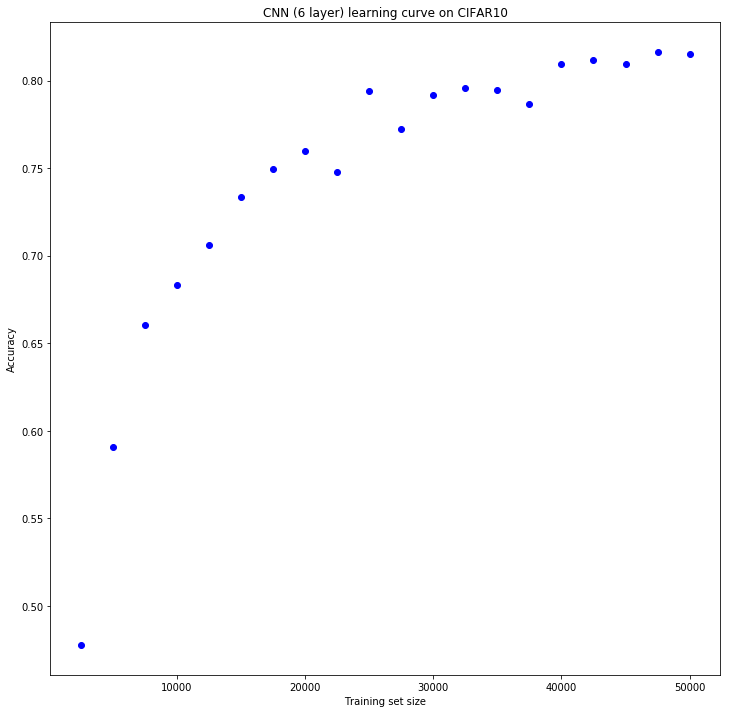

In [12]:
training_sizes = range(step_size, num_train + step_size, step_size)

plt.figure(figsize=(12,12))
plt.plot(training_sizes, val_acc, 'b.', label='Validation Accuracy', markersize=12)
plt.title('CNN (6 layer) learning curve on CIFAR10')
plt.ylabel('Accuracy')
plt.xlabel('Training set size')

The graph shows that between 10,000 and 20,000 training examples, adding more data produces significant performance improvements. It looks like even though the rate of performance gains has slowed and despite using data augmentation, adding more data is still an effective way to improve performance.


The code below allows us to analyse individual training runs. Let's plot the loss and accuracy for a particular training run.

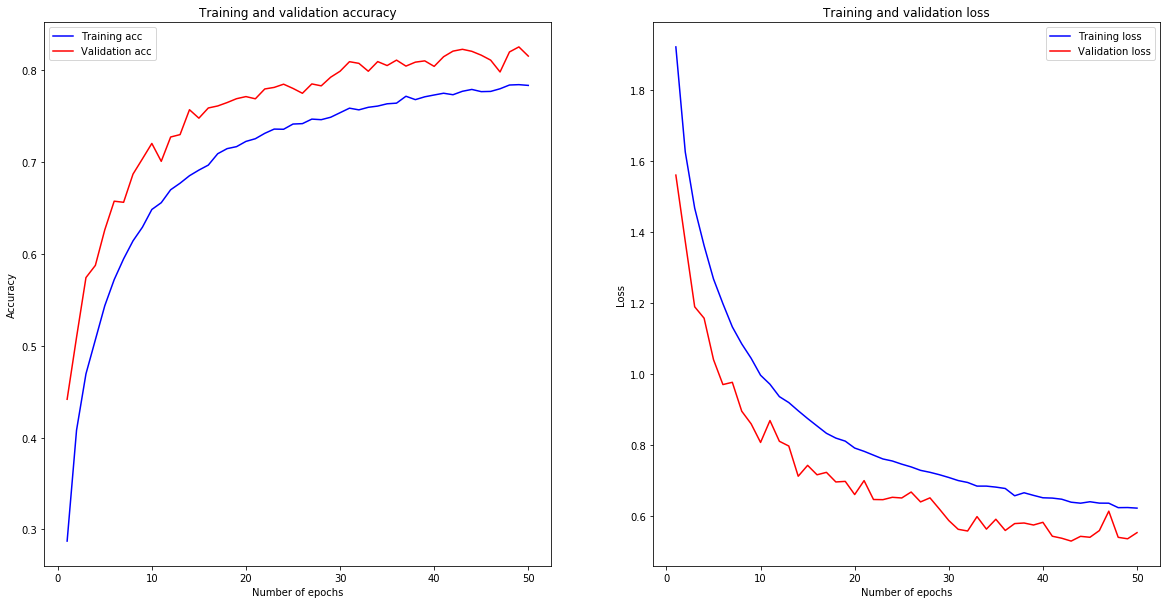

In [15]:
# select training run
training_run = 19

ys = range(1, epochs + 1)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.plot(ys, histories[training_run].history['acc'], 'b-', label='Training acc')
ax1.plot(ys, histories[training_run].history['val_acc'], 'r-', label='Validation acc')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Number of epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(ys, histories[training_run].history['loss'], 'b-', label='Training loss')
ax2.plot(ys, histories[training_run].history['val_loss'], 'r-', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Number of epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()